# Part 1: Construct a KG from unstructured data

This notebook illustrates the internal steps for the implementation of an NLP pipeline for constructing _knowledge graphs_ from unstructured data sources.

Presentation for GraphGeeks.org on 2024-08-14

## Set up

In [1]:
from IPython.display import display, HTML, Image, SVG

from collections import defaultdict
from dataclasses import dataclass
import itertools
import os
import typing
import warnings

from gliner_spacy.pipeline import GlinerSpacy
from icecream import ic
from pydantic import BaseModel
from pyinstrument import Profiler
import glirel
import matplotlib
import matplotlib.colors
import networkx as nx
import pandas as pd
import pyvis
import spacy
import transformers

Override specific Hugging Face error messages, since `transformers` and `tokenizers` have noisy logging.

In [2]:
transformers.logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "0"

Show a watermark of the OS, hardware, language environment, and dependent library versions.

In [3]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2025-01-14T00:10:28.920773-08:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.31.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.153.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

glirel      : 1.0.1
pyvis       : 0.3.2
spacy       : 3.7.5
networkx    : 3.4.2
gliner_spacy: 0.0.10
pandas      : 2.2.3
pydantic    : 2.10.4
IPython     : 8.31.0
transformers: 4.47.1
pyinstrument: 5.0.0
matplotlib  : 3.10.0



Start the stochastic stack trace profiler.

In [4]:
profiler: Profiler = Profiler()
profiler.start()

Define the model selections and parameter settings.

In [5]:
CHUNK_SIZE: int = 1024

GLINER_MODEL: str = "urchade/gliner_small-v2.1"

NER_LABELS: typing.List[ str] = [
    "Behavior",
    "City",
    "Company",    
    "Condition",
    "Conference",
    "Country",
    "Food",
    "Food Additive",
    "Hospital",
    "Organ",
    "Organization",
    "People Group",
    "Person",
    "Publication",
    "Research",
    "Science",
    "University",
]

RE_LABELS: dict = {
    "glirel_labels": {
        "no_relation": {},  
        "co_founder": {"allowed_head": ["PERSON"], "allowed_tail": ["ORG"]}, 
        "country_of_origin": {"allowed_head": ["PERSON", "ORG"], "allowed_tail": ["LOC", "GPE"]}, 
        "parent": {"allowed_head": ["PERSON"], "allowed_tail": ["PERSON"]}, 
        "followed_by": {"allowed_head": ["PERSON", "ORG"], "allowed_tail": ["PERSON", "ORG"]},  
        "spouse": {"allowed_head": ["PERSON"], "allowed_tail": ["PERSON"]},  
        "child": {"allowed_head": ["PERSON"], "allowed_tail": ["PERSON"]},  
        "founder": {"allowed_head": ["PERSON"], "allowed_tail": ["ORG"]},  
        "headquartered_in": {"allowed_head": ["ORG"], "allowed_tail": ["LOC", "GPE", "FAC"]},  
        "acquired_by": {"allowed_head": ["ORG"], "allowed_tail": ["ORG", "PERSON"]},  
        "subsidiary_of": {"allowed_head": ["ORG"], "allowed_tail": ["ORG", "PERSON"]}, 
    }
}

SPACY_MODEL: str = "en_core_web_md"

STOP_WORDS: typing.Set[ str ] = set([
    "PRON.it",
    "PRON.that",
    "PRON.they",
    "PRON.those",
    "PRON.we",
    "PRON.which",
    "PRON.who",
])

TR_ALPHA: float = 0.85
TR_LOOKBACK: int = 3

Load the models for `spaCy`, `GLiNER`, `GLiREL` -- this may take several minutes when run the first time.

In [6]:
nlp: spacy.Language = spacy.load(SPACY_MODEL)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    nlp.add_pipe(
        "gliner_spacy",
        config = {
            "gliner_model": GLINER_MODEL,
            "labels": NER_LABELS,
            "chunk_size": CHUNK_SIZE,
            "style": "ent",
        },
    )
        
    nlp.add_pipe(
        "glirel",
        after = "ner",
    );

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Define the global data structures -- which need to be reset for every run, not for each chunk iteration.

In [7]:
graph: nx.Graph = nx.Graph()
known_lemma: typing.List[ str ] = []

## Parse one text chunk

Define an input text chunk.

In [8]:
class TextChunk (BaseModel):
    uid: int
    url: str
    text: str
    
SAMPLE_CHUNK: TextChunk = TextChunk(
    uid = 1,
    url = "https://raw.githubusercontent.com/egodat/Churchill/refs/heads/master/We_shall_fight.txt",
    text = """
I have, myself, full confidence that if all do their duty, if nothing is neglected, and if the best arrangements are made, as they are being made, we shall prove ourselves once again able to defend our Island home, to ride out the storm of war, and to outlive the menace of tyranny, if necessary for years, if necessary alone. At any rate, that is what we are going to try to do. That is the resolve of His Majesty’s Government-every man of them. That is the will of Parliament and the nation. The British Empire and the French Republic, linked together in their cause and in their need, will defend to the death their native soil, aiding each other like good comrades to the utmost of their strength. Even though large tracts of Europe and many old and famous States have fallen or may fall into the grip of the Gestapo and all the odious apparatus of Nazi rule, we shall not flag or fail. We shall go on to the end, we shall fight in France, we shall fight on the seas and oceans, we shall fight with growing confidence and growing strength in the air, we shall defend our Island, whatever the cost may be, we shall fight on the beaches, we shall fight on the landing grounds, we shall fight in the fields and in the streets, we shall fight in the hills; we shall never surrender, and even if, which I do not for a moment believe, this Island or a large part of it were subjugated and starving, then our Empire beyond the seas, armed and guarded by the British Fleet, would carry on the struggle, until, in God’s good time, the New World, with all its power and might, steps forth to the rescue and the liberation of the old.
    """.strip(),
)

chunk: TextChunk = SAMPLE_CHUNK

Parse the input text.

In [9]:
doc: spacy.tokens.doc.Doc = list(
    nlp.pipe(
        [( chunk.text, RE_LABELS )],
        as_tuples = True,
    )
)[0][0]

Visualize the `spaCy` parse and `GLiNER` _named entity recognition_ results.

In [10]:
for sent in doc.sents:
    spacy.displacy.render(
        sent,
        style = "ent",
        jupyter = True,
    )

    parse_svg: str = spacy.displacy.render(
        sent,
        style = "dep",
        jupyter = True,
    )

    display(SVG(parse_svg))

/home/donbr/strwythura/.venv/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

## Layer 1: construct a lexical graph

Scan the document tokens to add lemmas to the _textgraph_.

In [11]:
for sent in doc.sents:
    node_seq: typing.List[ int ] = []
    ic(sent)

    for tok in sent:
        text: str = tok.text.strip()
        
        if tok.pos_ in [ "NOUN", "PROPN" ]:
            key: str = tok.pos_ + "." + tok.lemma_.strip().lower()
            print(tok.i, key, tok.text.strip())

            if key not in known_lemma:
                # create a new node
                known_lemma.append(key)
                node_id: int = known_lemma.index(key)
                node_seq.append(node_id)

                graph.add_node(
                    node_id,
                    key = key,
                    kind = "Lemma",
                    pos = tok.pos_,
                    text = text,
                    chunk = chunk.uid,
                    count = 1,
                )
            else:
                # link to an existing node, adding weight
                node_id = known_lemma.index(key)
                node_seq.append(node_id)

                node: dict = graph.nodes[node_id]
                node["count"] += 1

    # create the textrank edges
    ic(node_seq)

    for hop in range(TR_LOOKBACK):
        for node_id, node in enumerate(node_seq[: -1 - hop]):            
            neighbor: int = node_seq[hop + node_id + 1]
            graph.add_edge(
                node,
                neighbor,
                rel = "FOLLOWS_LEXICALLY",
            )

ic| sent: I have, myself, full confidence that if all do their duty, if nothing is neglected, and if the best arrangements are made, as they are being made, we shall prove ourselves once again able to defend our Island home, to ride out the storm of war, and to outlive the menace of tyranny, if necessary for years, if necessary alone.
ic| node_seq: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ic| sent: At any rate, that is what we are going to try to do.
ic| node_seq: [10]
ic| sent: That is the resolve of His Majesty’s Government-every man of them.
ic| node_seq: [11, 12, 13, 14]


6 NOUN.confidence confidence
12 NOUN.duty duty
23 NOUN.arrangement arrangements
43 PROPN.island Island
44 NOUN.home home
50 NOUN.storm storm
52 NOUN.war war
58 NOUN.menace menace
60 NOUN.tyranny tyranny
65 NOUN.year years
73 NOUN.rate rate
89 NOUN.resolve resolve
92 PROPN.majesty Majesty
94 PROPN.government Government
97 NOUN.man man


ic| sent: That is the will of Parliament and the nation.
ic| node_seq: [15, 16, 17]
ic| sent: The British Empire and the French Republic, linked together in their cause and in their need, will defend to the death their native soil, aiding each other like good comrades to the utmost of their strength.
ic| node_seq: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
ic| sent: Even though large

104 NOUN.will will
106 PROPN.parliament Parliament
109 NOUN.nation nation
112 PROPN.british British
113 PROPN.empire Empire
116 PROPN.french French
117 PROPN.republic Republic
123 NOUN.cause cause
127 NOUN.need need
133 NOUN.death death
136 NOUN.soil soil
143 NOUN.comrade comrades
146 NOUN.utmost utmost
149 NOUN.strength strength


 tracts of Europe and many old and famous States have fallen or may fall into the grip of the Gestapo and all the odious apparatus of Nazi rule, we shall not flag or fail.
ic| node_seq: [29, 30, 31, 32, 33, 34, 35, 36]
ic| sent: We shall go on to the end, we shall fight in France, we shall fight on the seas and oceans, we shall fight with growing confidence and growing strength in the air, we shall defend our Island, whatever the cost may be, we shall fight on the beaches, we shall fight on the landing grounds, we shall fight in the fields and in the streets, we shall fight in the hills; we shall never surrender, and even if, which I do not for a moment believe

154 NOUN.tract tracts
156 PROPN.europe Europe
162 PROPN.states States
170 NOUN.grip grip
173 PROPN.gestapo Gestapo
178 NOUN.apparatus apparatus
180 PROPN.nazi Nazi
181 NOUN.rule rule


, this Island or a large part of it were subjugated and starving, then our Empire beyond the seas, armed and guarded by the British Fleet, would carry on the struggle, until, in God’s good time, the New World, with all its power and might, steps forth to the rescue and the liberation of the old.
ic| node_seq: [37,
               38,
               39,
               40,
               0,
               28,
               41,
               3,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
               3,
               50,
               19,
               39,
               18,
               51,
               52,
               53,
               54,
               55,
               56,
               57,
               58,
               59,
               60]


196 NOUN.end end
202 PROPN.france France
209 NOUN.sea seas
211 NOUN.ocean oceans
218 NOUN.confidence confidence
221 NOUN.strength strength
224 NOUN.air air
230 PROPN.island Island
234 NOUN.cost cost
243 NOUN.beach beaches
250 NOUN.landing landing
251 NOUN.ground grounds
258 NOUN.field fields
262 NOUN.street streets
269 NOUN.hill hills
286 NOUN.moment moment
290 PROPN.island Island
294 NOUN.part part
304 PROPN.empire Empire
307 NOUN.sea seas
314 PROPN.british British
315 PROPN.fleet Fleet
321 NOUN.struggle struggle
326 PROPN.god God
329 NOUN.time time
332 PROPN.new New
333 PROPN.world World
338 NOUN.power power
340 NOUN.might might
346 NOUN.rescue rescue
349 NOUN.liberation liberation


Keep track of the sentence numbers, which we'll use later for entity co-occurrence links.

In [12]:
sent_map: typing.Dict[ spacy.tokens.span.Span, int ] = {}

for sent_id, sent in enumerate(doc.sents):
    sent_map[sent] = sent_id

## Layer 2: overlay entities onto the graph

Classify spans as potential entities.

Note that if we'd run [_entity resolution_](https://neo4j.com/developer-blog/entity-resolved-knowledge-graphs/) previously from _structured_ or _semi-structured_ data sources to generate a "backbone" for the knowledge graph, then we use the contextualized _surface forms_ from that phase to perform _entity linking_ on the entities extracted here from _unstructured_ data.

In [13]:
@dataclass(order=False, frozen=False)
class Entity:
    loc: typing.Tuple[ int ]
    key: str
    text: str
    label: str
    chunk_id: int
    sent_id: int
    span: spacy.tokens.span.Span
    node: typing.Optional[ int ] = None


span_decoder: typing.Dict[ tuple, Entity ] = {}


def make_entity (
    span: spacy.tokens.span.Span,
    chunk: TextChunk,
    ) -> Entity:
    """
Instantiate one `Entity` dataclass object, adding it to the working "vocabulary".
    """
    key: str = " ".join([
        tok.pos_ + "." + tok.lemma_.strip().lower()
        for tok in span
    ])
    
    ent: Entity = Entity(
        ( span.start, span.end, ),
        key,
        span.text,
        span.label_,
        chunk.uid,
        sent_map[span.sent],
        span,
    )

    if ent.loc not in span_decoder:
        span_decoder[ent.loc] = ent
        ic(ent)

    return ent

In [14]:
for span in doc.ents:
    make_entity(span, chunk)

for span in doc.noun_chunks:
    make_entity(span, chunk)

ic| ent: Entity(loc=(106, 107),
                key='PROPN.parliament',
                text='Parliament',
                label='Organization',
                chunk_id=1,
                sent_id=3,
                span=Parliament,
                node=None)
ic| ent: Entity(loc=(112, 114),
                key='PROPN.british PROPN.empire',
                text='British Empire',
                label='Organization',
                chunk_id=1,
                sent_id=4,
                span=British Empire,
                node=None)
ic| ent: Entity(loc=(116, 118),
                key='PROPN.french PROPN.republic',
                text='French Republic',
                label='Country',
                chunk_id=1,
                sent_id=4,
                span=French Republic,
                node=None)
ic| ent: Entity(loc=(173, 174),
                key='PROPN.gestapo',
                text='Gestapo',
                label='Organization',
                chunk_id=1,
                sen

Overlay the inferred entity spans atop the base layer constructed by _textgraph_ analysis of the `spaCy` parse trees.

In [15]:
def extract_entity (
    ent: Entity,
    ) -> None:
    """
Link one `Entity` into the existing graph.
    """
    if ent.key not in known_lemma:
        # add a new Entity node to the graph and link to its component Lemma nodes
        known_lemma.append(ent.key)
        node_id: int = known_lemma.index(ent.key)
        
        graph.add_node(
            node_id,
            key = ent.key,
            kind = "Entity",
            label = ent.label,
            pos = "NP",
            text = ent.text,
            chunk = ent.chunk_id,
            count = 1,
        )

        for tok in ent.span:
            tok_key: str = tok.pos_ + "." + tok.lemma_.strip().lower()

            if tok_key in known_lemma:
                tok_idx: int = known_lemma.index(tok_key)

                graph.add_edge(
                    node_id,
                    tok_idx,
                    rel = "COMPOUND_ELEMENT_OF",
                )
    else:
        node_id: int = known_lemma.index(ent.key)
        node: dict = graph.nodes[node_id]
        # promote to an Entity, in case the node had been a Lemma
        node["kind"] = "Entity"
        node["chunk"] = ent.chunk_id
        node["count"] += 1

        # select the more specific label
        if "label" not in node or node["label"] == "NP":
          node["label"] = ent.label

    ent.node = node_id

In [16]:
for ent in span_decoder.values():
    if ent.key not in STOP_WORDS:
        extract_entity(ent)
        ic(ent)

ic| ent: Entity(loc=(106, 107),
                key='PROPN.parliament',
                text='Parliament',
                label='Organization',
                chunk_id=1,
                sent_id=3,
                span=Parliament,
                node=16)
ic| ent: Entity(loc=(112, 114),
                key='PROPN.british PROPN.empire',
                text='British Empire',
                label='Organization',
                chunk_id=1,
                sent_id=4,
                span=British Empire,
                node=61)
ic| ent: Entity(loc=(116, 118),
                key='PROPN.french PROPN.republic',
                text='French Republic',
                label='Country',
                chunk_id=1,
                sent_id=4,
                span=French Republic,
                node=62)
ic| ent: Entity(loc=(173, 174),
                key='PROPN.gestapo',
                text='Gestapo',
                label='Organization',
                chunk_id=1,
                sent_id=5

Report the relations inferred by `GLiREL`.

In [17]:
relations: typing.List[ dict ] = sorted(
    doc._.relations,
    key = lambda x: x["score"],
    reverse = True,
)

for item in relations:
    src_loc: typing.Tuple[ int ] = tuple(item["head_pos"])
    dst_loc: typing.Tuple[ int ] = tuple(item["tail_pos"])
    skip_rel: bool = False

    if src_loc not in span_decoder:
        print("MISSING src entity:", item["head_text"], item["head_pos"])
        
        src_ent: Entity = make_entity(
            doc[ item["head_pos"][0] : item["head_pos"][1] ],
            chunk,
        )

        if src_ent.key in STOP_WORDS:
            skip_rel = True
        else:
            extract_entity(src_ent)

    if dst_loc not in span_decoder:
        print("MISSING dst entity:", item["tail_text"], item["tail_pos"])

        dst_ent: Entity = make_entity(
            doc[ item["tail_pos"][0] : item["tail_pos"][1] ],
            chunk,
        )

        if dst_ent.key in STOP_WORDS:
            skip_rel = True
        else:
            extract_entity(dst_ent)

    # link the connected nodes
    if not skip_rel:
        src_ent = span_decoder[src_loc]
        dst_ent = span_decoder[dst_loc]

        rel: str = item["label"].strip().replace(" ", "_").upper()
        prob: float = round(item["score"], 3)

        print(f"{src_ent.text} {src_ent.node} -> {rel} -> {dst_ent.text} {dst_ent.node} | {prob}")

        graph.add_edge(
            src_ent.node,
            dst_ent.node,
            rel = rel,
            prob = prob,
        )

Connect the co-occurring entities.

In [18]:
ent_map: typing.Dict[ int, typing.Set[ int ]] = defaultdict(set)

for ent in span_decoder.values():
    if ent.node is not None:
        ent_map[ent.sent_id].add(ent.node)    

for sent_id, nodes in ent_map.items():
    for pair in itertools.combinations(list(nodes), 2):
        if not graph.has_edge(*pair):
            graph.add_edge(
                pair[0],
                pair[1],
                rel = "CO_OCCURS_WITH",
                prob = 1.0,
            )

Run eigenvalue centrality (i.e., _Personalized PageRank_) to rank the entities.

In [19]:
for node, rank in nx.pagerank(graph, alpha = TR_ALPHA, weight = "count").items():
    graph.nodes[node]["rank"] = rank

Report the top-ranked entities extracted from this text chunk.

In [20]:
df: pd.DataFrame = pd.DataFrame([
    node_attr
    for node, node_attr in graph.nodes(data = True)
    if node_attr["kind"] == "Entity"
]).sort_values(by = [ "rank", "count" ], ascending = False)

df.head(20)

,key,kind,pos,text,chunk,count,label,rank
11,PRON.i,Entity,NP,I,1,2,Person,0.016786
8,NOUN.might,Entity,NOUN,might,1,2,NP,0.013284
7,NOUN.ocean,Entity,NOUN,oceans,1,2,NP,0.012997
5,PROPN.gestapo,Entity,PROPN,Gestapo,1,2,Organization,0.012857
6,PROPN.france,Entity,PROPN,France,1,2,Country,0.011825
55,DET.the NOUN.landing NOUN.ground,Entity,NP,the landing grounds,1,1,NP,0.011494
65,PROPN.god PART.’s ADJ.good NOUN.time,Entity,NP,God’s good time,1,1,NP,0.011446
66,DET.the PROPN.new PROPN.world,Entity,NP,the New World,1,1,NP,0.011400
13,PROPN.british PROPN.fleet,Entity,NP,British Fleet,1,1,Organization,0.011348
63,DET.the PROPN.british PROPN.fleet,Entity,NP,the British Fleet,1,1,NP,0.011348


## Visualize the results

Use `pyvis` to provide an interactive visualization of both layers of the graph, so far...

In [21]:
pv_net: pyvis.network.Network = pyvis.network.Network(
    height = "750px",
    width = "100%",
    notebook = True,
    cdn_resources = "remote",
)

for node_id, node_attr in graph.nodes(data = True):
    if node_attr["kind"] == "Entity":
        color: str = "hsl(65, 46%, 58%)"
        size: int = round(200 * node_attr["rank"])
    else:
        color = "hsla(72, 10%, 90%, 0.95)"
        size = round(30 * node_attr["rank"])

    pv_net.add_node(
        node_id,
        label = node_attr["text"],
        title = node_attr.get("label"),
        color = color,
        size = size,
    )

for src_node, dst_node, edge_attr in graph.edges(data = True):
    pv_net.add_edge(
        src_node,
        dst_node,
        title = edge_attr.get("rel"),
    )

pv_net.toggle_physics(True)
pv_net.show("graphrag_contruct.html")

graphrag_contruct.html


Show a cluster analysis of the _lexical graph_.

In [22]:
communities: typing.Generator = nx.community.louvain_communities(graph)

comm_map: typing.Dict[ int, int ] = {
    node_id: i
    for i, comm in enumerate(communities)
    for node_id in comm
}
                                                                                                                            
xkcd_colors: typing.List[ str ] = list(matplotlib.colors.XKCD_COLORS.values())

colors: typing.List[ str ] = [
    xkcd_colors[comm_map[n]]
    for n in list(graph.nodes())
]
                                                                                                                                         
labels: typing.Dict[ int, str ] = {
    node_id: node_attr["text"]
    for node_id, node_attr in graph.nodes(data = True)
}

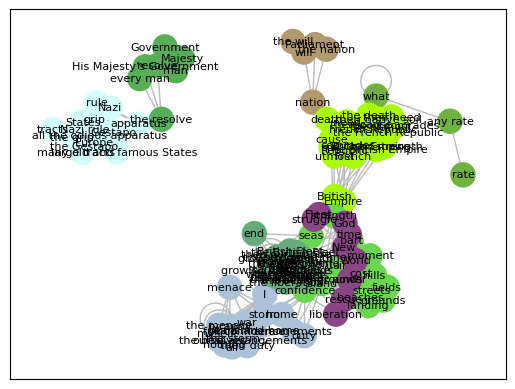

In [23]:
SPRING_DISTANCE: float = 2.5
                                                                                                                                     
nx.draw_networkx(
    graph,
    pos = nx.spring_layout(
        graph,
        k = SPRING_DISTANCE / len(communities),
    ),
    labels = labels,
    node_color = colors,
    edge_color = "#bbb",
    with_labels = True,
    font_size = 8,
)

## Tear down

How much did the global data structures grow?

In [24]:
ic(len(known_lemma))
ic(len(span_decoder))
ic(len(graph.nodes()));

ic| len(known_lemma): 122
ic| len(span_decoder): 92
ic| len(graph.nodes()): 122


Stop the profiler and report the performance measures.

In [25]:
profiler.stop()
profiler.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 00:10:28  Samples:  15019
 /_//_/// /_\ / //_// / //_'/ //     Duration: 27.568    CPU time: 37.306
/   _/                      v5.0.0

Profile at /tmp/ipykernel_586519/382364451.py:2

27.569 _UnixSelectorEventLoop._run_once  asyncio/base_events.py:1832
├─ 25.875 Handle._run  asyncio/events.py:78
│     [11 frames hidden]  ipykernel, IPython
│        25.483 ZMQInteractiveShell.run_ast_nodes  IPython/core/interactiveshell.py:3418
│        ├─ 11.061 <module>  ../ipykernel_586519/2312294158.py:1
│        │  ├─ 9.843 English.add_pipe  spacy/language.py:764
│        │  │     [128 frames hidden]  spacy, confection, glirel, huggingfac...
│        │  └─ 1.219 load  spacy/__init__.py:27
│        │        [8 frames hidden]  spacy, en_core_web_md
│        ├─ 6.905 <module>  ../ipykernel_586519/1388022593.py:1
│        │  └─ 6.904 make_entity  ../ipykernel_586519/683571985.py:16
│        │     └─ 6.899 IceCreamDebugger.__call__  icecream/icecream.py:2

## Quality checks

Are there any prounoun lemmas that we need to add to the `STOP_WORDS` list? Until we have a good _coreference_ stage in this workflow, the pronouns are too generic and tend to distort the graph results. NB: compound references are "contained" and not a problem.

In [26]:
for x in known_lemma:
    if "PRON" in x:
        print(x)

PRON.i
PRON.myself
PRON.all
PRON.their NOUN.duty
PRON.nothing
PRON.ourselves
PRON.our PROPN.island NOUN.home
PRON.what
PRON.his PROPN.majesty PART.’s PROPN.government
PRON.their NOUN.cause
PRON.their NOUN.need
PRON.their ADJ.native NOUN.soil
PRON.their NOUN.strength
PRON.our PROPN.island
PRON.whatever
ADV.then PRON.our PROPN.empire
DET.all PRON.its NOUN.power


Which nodes should we promote to the next level?

In [27]:
kept_nodes: typing.Set[ int ] = set()

for node_id, node_attr in graph.nodes(data = True):
    if node_attr["kind"] == "Entity":
        print(node_id, node_attr["key"], node_attr["rank"], node_attr["label"], node_attr["text"], node_attr["chunk"])
        kept_nodes.add(node_id)

6 NOUN.war 0.0098111775033587 NP war 1
8 NOUN.tyranny 0.008615899671334963 NP tyranny 1
9 NOUN.year 0.007987572133038238 NP years 1
16 PROPN.parliament 0.010006387055565766 Organization Parliament 1
30 PROPN.europe 0.010769494039188714 NP Europe 1
33 PROPN.gestapo 0.012856737431860341 Organization Gestapo 1
38 PROPN.france 0.0118251983712727 Country France 1
40 NOUN.ocean 0.01299687812527174 NP oceans 1
58 NOUN.might 0.013283865579100655 NP might 1
61 PROPN.british PROPN.empire 0.008966661588104639 Organization British Empire 1
62 PROPN.french PROPN.republic 0.009221807962451192 Country French Republic 1
63 PRON.i 0.016786228845709385 Person I 1
64 VERB.starve 0.010507516238140457 Condition starving 1
65 PROPN.british PROPN.fleet 0.01134829439631528 Organization British Fleet 1
66 PRON.myself 0.007840024852165438 NP myself 1
67 ADJ.full NOUN.confidence 0.007894567072435172 NP full confidence 1
68 PRON.all 0.007840024852165438 NP all 1
69 PRON.their NOUN.duty 0.00805276492968016 NP thei

Which edges should we promote to the next level?

In [28]:
skip_rel: typing.Set[ str ] = set([ "FOLLOWS_LEXICALLY", "COMPOUND_ELEMENT_OF" ])

for src_id, dst_id, edge_attr in graph.edges(data = True):
    if src_id in kept_nodes and dst_id in kept_nodes:
        rel: str = edge_attr["rel"]

        if rel not in skip_rel:
            print(src_id, dst_id, rel, edge_attr["prob"])

6 66 CO_OCCURS_WITH 1.0
6 67 CO_OCCURS_WITH 1.0
6 68 CO_OCCURS_WITH 1.0
6 69 CO_OCCURS_WITH 1.0
6 70 CO_OCCURS_WITH 1.0
6 71 CO_OCCURS_WITH 1.0
6 72 CO_OCCURS_WITH 1.0
6 73 CO_OCCURS_WITH 1.0
6 74 CO_OCCURS_WITH 1.0
6 75 CO_OCCURS_WITH 1.0
6 63 CO_OCCURS_WITH 1.0
8 66 CO_OCCURS_WITH 1.0
8 67 CO_OCCURS_WITH 1.0
8 68 CO_OCCURS_WITH 1.0
8 69 CO_OCCURS_WITH 1.0
8 70 CO_OCCURS_WITH 1.0
8 71 CO_OCCURS_WITH 1.0
8 72 CO_OCCURS_WITH 1.0
8 73 CO_OCCURS_WITH 1.0
8 74 CO_OCCURS_WITH 1.0
8 75 CO_OCCURS_WITH 1.0
8 63 CO_OCCURS_WITH 1.0
9 66 CO_OCCURS_WITH 1.0
9 67 CO_OCCURS_WITH 1.0
9 68 CO_OCCURS_WITH 1.0
9 69 CO_OCCURS_WITH 1.0
9 70 CO_OCCURS_WITH 1.0
9 71 CO_OCCURS_WITH 1.0
9 72 CO_OCCURS_WITH 1.0
9 73 CO_OCCURS_WITH 1.0
9 74 CO_OCCURS_WITH 1.0
9 75 CO_OCCURS_WITH 1.0
9 63 CO_OCCURS_WITH 1.0
16 81 CO_OCCURS_WITH 1.0
16 82 CO_OCCURS_WITH 1.0
30 96 CO_OCCURS_WITH 1.0
30 97 CO_OCCURS_WITH 1.0
30 94 CO_OCCURS_WITH 1.0
30 92 CO_OCCURS_WITH 1.0
30 93 CO_OCCURS_WITH 1.0
30 95 CO_OCCURS_WITH 1.0
33 96 CO